# Explanation

Convert 3-lead ECG signals (commonly leads I, II, and III) to 12-lead ECG signals using LSTM, by train a model that maps the 3-lead input signals to the corresponding 12-lead output signals. The neural network learns to approximate the nonlinear relationship between the 3-lead and 12-lead ECG signals. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from scipy.signal import savgol_filter

2024-09-22 19:53:39.773015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 19:53:39.879612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-22 19:53:39.879645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-22 19:53:39.898605: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 19:53:40.652375: W tensorflow/stream_executor/platform/de

### Prepare the data

The dataset that contains 12-lead ECG signals. The 3-lead signals will be the input, and the 12-lead signals will be the output. Load ECG dataset X_3_lead: 3-lead ECG signals (input) y_12_lead: corresponding 12-lead ECG signals (output) Example dummy data (replace this with your real data)

Step 1: Load the dataset
CSV file

In [2]:
data = pd.read_csv('MUSE_20180111_155633_99000.csv')

Assume the first 3 columns are 3-lead ECG signals (input) and the next 12 are the 12-lead ECG signals (output)

In [3]:
input_columns = ['I', 'II', 'aVR']  

output_columns = ['I', 'II', 'III','aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']  

X = data[input_columns].values 

Y = data[output_columns].values 

## Data Preprocessing

The 3-lead and 12-lead signals are scaled using MinMaxScaler to normalize them, which is a common practice for neural network training. We are working with 10 seconds of ECG data, and ECG device records data at 500 Hz (500 points per second), the sequence would have time_steps = 5000 (10 seconds × 500 points/second). Each sample would therefore contain 5000 time steps, representing the 10-second duration of the signal. 1000 time steps: Each sample consists of 1000 time points or intervals. 3 features: Each time point has 3 features corresponding to the 3-lead ECG values.

In [4]:
# Step 3: Data Preprocessing
# Normalize the input and output data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()


# Scale the data
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


# Reshape the input for LSTM (samples, time_steps, features)
# Suppose we have 1000 samples, 500 time steps per sample, and 3 features per time step (3-lead ECG)
samples = 1
time_steps = 1
features = 3


# Assuming each row is a single time step (time_steps=1), and leads are the features.
# Adjust if you have multiple time steps in your data
X_reshaped = X_scaled.reshape(X_scaled.shape[0] // time_steps, time_steps, X_scaled.shape[1])
Y_reshaped = Y_scaled.reshape(Y_scaled.shape[0] // time_steps, time_steps, Y_scaled.shape[1])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, random_state=101)

In [5]:
y_test.shape

(1000, 1, 12)

### Define the model

Use The LSTM (Long Short-Term Memory) to map the 3-lead signals to the 12-lead signals. This is a basic model. Depending on the complexity of the data, we might need to adjust the architecture (e.g., adding more hidden layers, neurons, or even using more advanced techniques such as recurrent or convolutional layers). The LSTM network is a type of recurrent neural network (RNN) that is well-suited for time-series data like ECG signals. The idea is to use the 3-lead signals as input and train the LSTM to predict the missing leads

In [6]:
#Define an LSTM model to convert 3-lead ECG to 12-lead ECG.
model = tf.keras.models.Sequential()

# Build the LSTM model
# LSTM Layer
input_shape=(time_steps, X_train.shape[2])
model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape))
# Dropout to prevent overfitting
model.add(tf.keras.layers.Dropout(0.2))  

# Another LSTM Layer
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))


# Output layer: 12 values for each time step (for 12-lead ECG output)
model.add(tf.keras.layers.Dense(12))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2024-09-22 19:53:42.398623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-22 19:53:42.399384: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-22 19:53:42.399418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-b38698f4-29f7-4f9e-9e65-c8b0865cb7d7): /proc/driver/nvidia/version does not exist
2024-09-22 19:53:42.401049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

During training, the weights $ 𝑊_{1},𝑊_{2},𝑊_{3},𝑊{4} $ and biases $ 𝑏_{1},𝑏_{2},𝑏_{3},𝑏_{4} $ are updated using backpropagation to minimize the loss function.

In [7]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), 
callbacks=[early_stopping])

Epoch 1/200
63/63 [==============================] - 4s 20ms/step - loss: 0.1216 - val_loss: 0.0308
Epoch 2/200
63/63 [==============================] - 1s 11ms/step - loss: 0.0252 - val_loss: 0.0223
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0157 - val_loss: 0.0106
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 5/200
63/63 [==============================] - 1s 11ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0082 - val_loss: 0.0061
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 8/200
63/63 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 9/200
63/63 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 10/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0018

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            67584     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense (Dense)               (None, 1, 12)             1548      
                                                                 
Total params: 200,716
Trainable params: 200,716
Non-trainable params: 0
_________________________________________________________________


### Evaluation

After training the LSTM, we need to evaluate the model performance on a test set to ensure that it generalizes well. This involves measuring the difference between the predicted 12-lead ECG signals and the actual 12-lead ECG signals.

In [9]:
# Step 6: Evaluation
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

32/32 [==============================] - 0s 2ms/step - loss: 0.0011
Test Loss: 0.0010703604202717543


In [10]:
y_pred= model.predict(X_test)

32/32 [==============================] - 1s 1ms/step


In [11]:
# reshape the evualtion data to two diminsions arrays 
y_test = y_test.reshape((y_test.shape[0], -1)) 
y_pred = y_pred.reshape((y_pred.shape[0], -1)) 

###  Evaluation Metrics:

1- Mean Squared Error (MSE): Measures the average squared difference between the actual and predicted values. A lower value indicates better performance. 2- Root Mean Squared Error (RMSE) is a common evaluation metric that measures the square root of the average of the squared differences between predicted and actual values.
3- Mean Absolute Error (MAE): Measures the average absolute difference between the actual and predicted values.
4- R-squared (R2 Score): Indicates how well the model fits the data. The R2 score ranges from 0 to 1, with 1 representing a perfect fit.

In [12]:
# Step 9: Evaluation Metrics
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.0010703603401113245
Root Mean Squared Error (RMSE): 0.03271636196326426
Mean Absolute Error (MAE): 0.018883854651049144
R² Score: 0.9633637189157921


## Inverse Scaling

Since we scaled the 3-lead and 12-lead ECG signals before feeding them into the model, we need to inverse-transform both the predicted values and the actual test data back to their original scales.

In [13]:
# Step 8: Inverse Scaling
# Inverse transform the predicted and actual values back to the original scale
y_pred = scaler_Y.inverse_transform(y_pred)
y_true = scaler_Y.inverse_transform(y_test)

## Plotting

The actual and predicted 3-lead and 12-lead ECG signals for a few samples are plotted to inspect how well the model is performing visually. The actual signals are plotted as solid lines, while the predicted signals are shown as dashed lines.

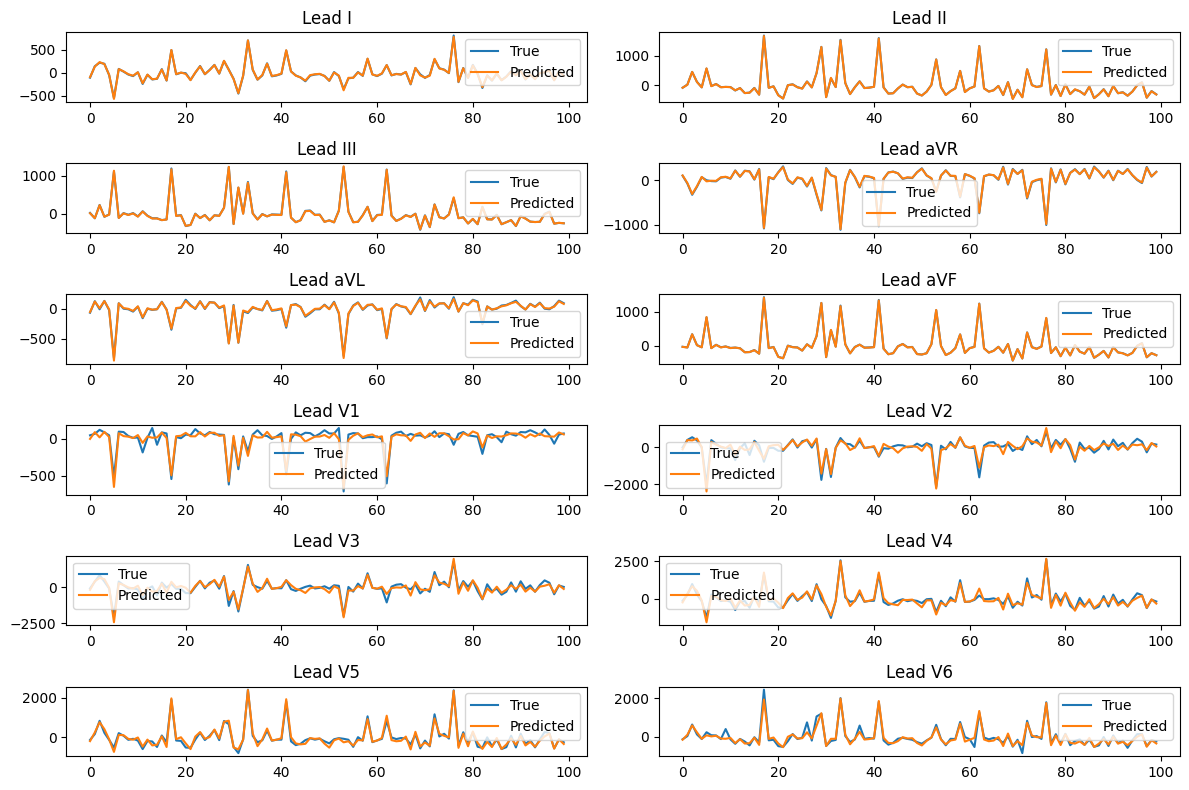

In [15]:
# Step 10: Visualizing the results
# Visualize the first few samples of the actual vs predicted 12-lead ECGs
plt.figure(figsize=(12, 8))
for i in range(12):  # Plot each lead
    plt.subplot(6, 2, i + 1)
    plt.plot(y_true[:100, i], label='True')
    plt.plot(y_pred[:100, i], label='Predicted')
    plt.title(f'Lead {output_columns[i]}')
    plt.legend()
plt.tight_layout()
plt.show()

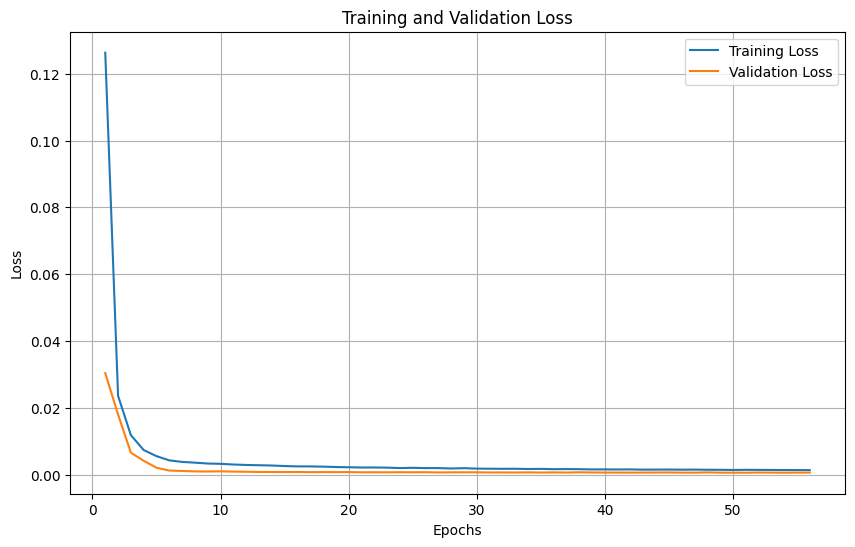

In [ ]:
# Extracting the loss and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
epochs_range = range(1, len(loss) + 1)

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b38698f4-29f7-4f9e-9e65-c8b0865cb7d7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>